# Augmentations of EEG-signals

In [1]:
import torch
import numpy as np
from datasets.augmentations import *
from datasets.SHHS_dataset_timeonly import SHHS_dataset_1
import matplotlib.pyplot as plt

In [2]:
# A function for plotting
def plot_augmentation(x, x_aug):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.plot(x.squeeze(), linewidth=1.0, label="Original eeg-signal")
    plt.plot(x_aug.squeeze(), linewidth=1.0, label="Augmented eeg-signal")
    plt.legend(loc="upper left")

## DC-shift

In [3]:
ds = SHHS_dataset_1('../../thesis01/data/', 1, 2)
x = ds.__getitem__(0)[0]
dc = DCShift(mini=1,
             maxi=5,
             prob=1,
             batch_size=1)
x_dc = dc(x)

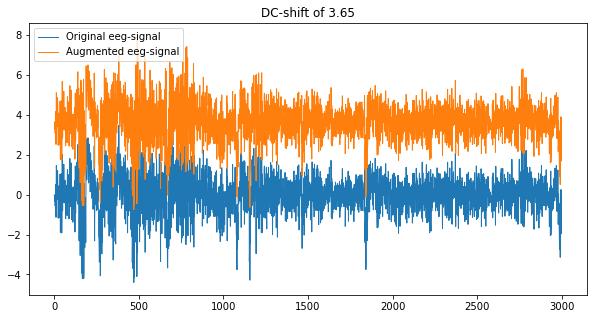

In [4]:
plot_augmentation(x, x_dc)
plt.title(f"DC-shift of {dc.u.item():.2f}")
plt.show()

## Amplitude scale

Text(0.5, 1.0, 'Amplitude shift of 0.72')

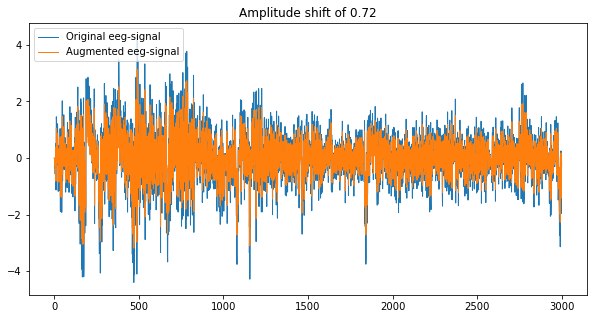

In [5]:
am = AmplitudeScale(mini=0.5,
                    maxi=0.75,
                    prob=1,
                    batch_size=1)
x_am = am(x)
plot_augmentation(x, x_am)
plt.title(f"Amplitude shift of {am.u.item():.2f}")

## Time shift

Text(0.5, 1.0, 'Time shift of 342')

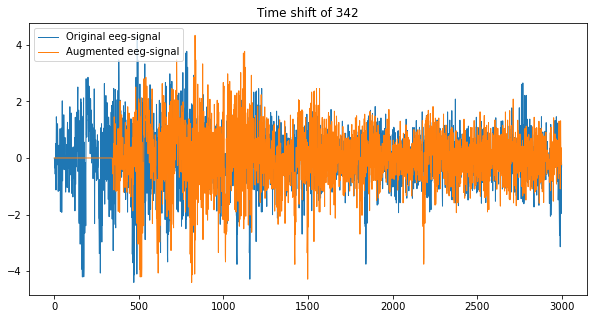

In [6]:
ts = TimeShift(mini=200,
               maxi=400,
               prob=1,
               batch_size=1)
x_ts = ts(x)
plot_augmentation(x, x_ts)
plt.title(f"Time shift of {int(ts.u.item())}")

## Zero Mask

Text(0.5, 1.0, 'Zero mask of 489')

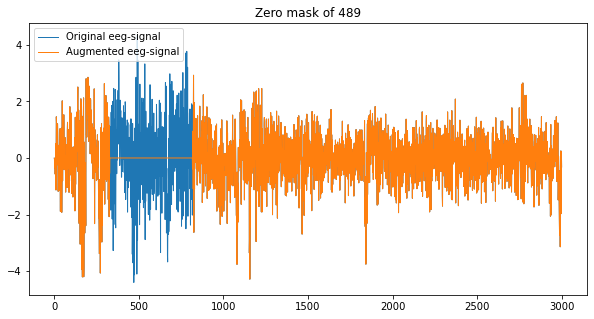

In [7]:
zm = ZeroMask(mini=400,
              maxi=600,
              prob=1,
              batch_size=1)
x_zm = zm(x)
plot_augmentation(x, x_zm)
plt.title(f"Zero mask of {int(zm.u.item())}")

## Gaussian noise

Text(0.5, 1.0, 'Additive gaussian noise of stdev: 0.55')

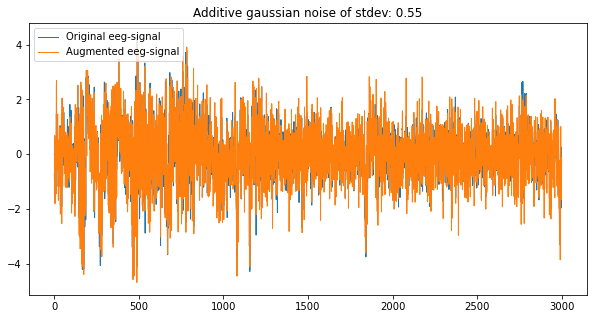

In [8]:
gn = GaussianNoise(mini=0.4,
                   maxi=0.6,
                   prob=1,
                   batch_size=1)
x_gn = gn(x)
plot_augmentation(x, x_gn)
plt.title(f"Additive gaussian noise of stdev: {gn.u.item():.2f}")

## Band stop filter: TODO